# Семинар 9. Деревья решений

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

cm_bright = ListedColormap(['red', 'blue'])
cm = plt.cm.get_cmap('RdBu')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [26]:
from sklearn import set_config

set_config(display='diagram')

In [27]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve)


def classification_metrics(true, pred, prob=None, verbose=False, plot=False):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    f1 = f1_score(true, pred)
    roc_auc = roc_auc_score(true, pred)
    
    if verbose:
        print('Accuracy:', acc)
        print('Precision:', prec)
        print('Recall:', rec)
        print('F1-score:', f1)
        print('AUC ROC:', roc_auc)
        print()
    
    return acc, prec, rec, f1, roc_auc

In [28]:
# вспомогательная функция
def plot_classification(X, y, model):
    pred = model.predict(X)
    
    idx = (y == pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='blue', label='true=1, pred=1')

    idx = (y != pred) & (y == 1)
    plt.scatter(X[idx, 0], X[idx, 1], color='cyan', label='true=1, pred=0')

    idx = (y == pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='red', label='true=0, pred=0')

    idx = (y != pred) & (y == 0)
    plt.scatter(X[idx, 0], X[idx, 1], color='yellow', label='true=0, pred=1')

def plot_decision_map(X, y, model, proba=False):
    X1, X2 = X[:, 0], X[:, 1]
    
    x1_low, x1_high = X1.min(), X1.max()
    x2_low, x2_high = X2.min(), X2.max()
    d1, d2 = x1_high - x1_low, x2_high - x2_low
    
    x1_low -= d1 * 0.1
    x2_low -= d2 * 0.1
    x1_high += d1 * 0.1
    x2_high += d2 * 0.1
    
    
    X1 = np.linspace(x1_low, x1_high, 128)
    X2 = np.linspace(x2_low, x2_high, 128)
    X1, X2 = np.meshgrid(X1, X2)
    Z = np.c_[X1.flatten(), X2.flatten()]
    
    if proba:
        Z = model.predict_proba(Z)[:, 1]
        Z = Z.reshape(X1.shape)
    else:
        Z = model.predict(Z).reshape(X1.shape)

    cmap = cm if proba else cm_bright
    plt.contourf(X1, X2, Z, cmap=cmap, alpha=0.2)
    
def plot_all(X, y, model, proba=False, title=''):
    plot_classification(X, y, model)
    plot_decision_map(X, y, model, proba=proba)
    
    plt.title(title)
    plt.legend()

# 1. Классификация

## 1.1. Синтетические данные

In [63]:
from sklearn.datasets import make_classification, make_circles, make_moons
from sklearn.model_selection import train_test_split

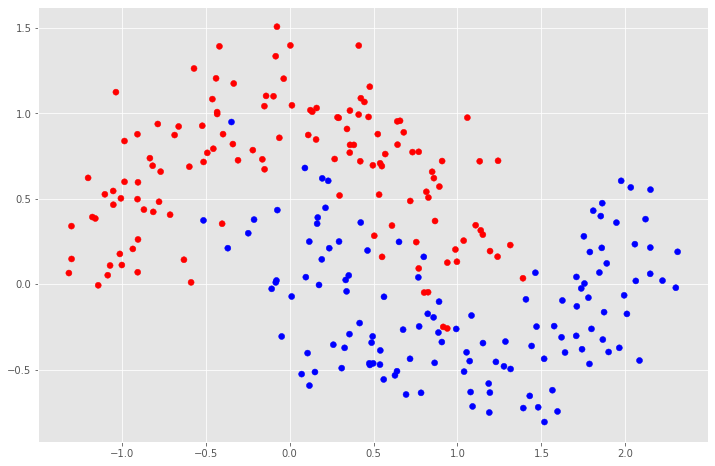

In [64]:
X, y = make_moons(n_samples=256, 
                  shuffle=True,
                  noise=0.2,
                  random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
plt.show()

In [65]:
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier()

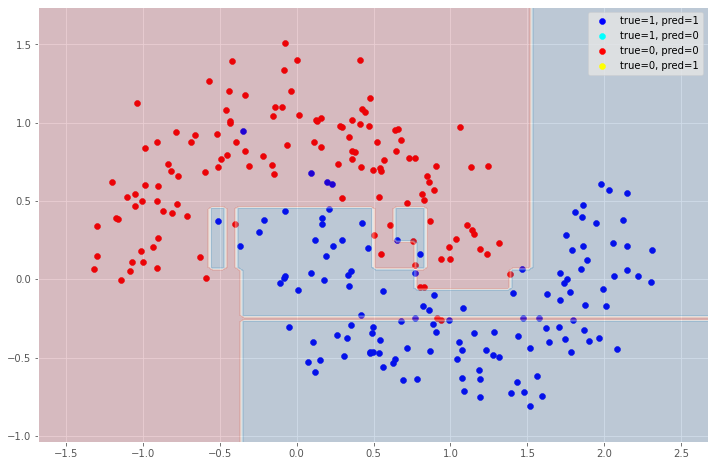

In [66]:
plot_all(X, y, model, proba=True)

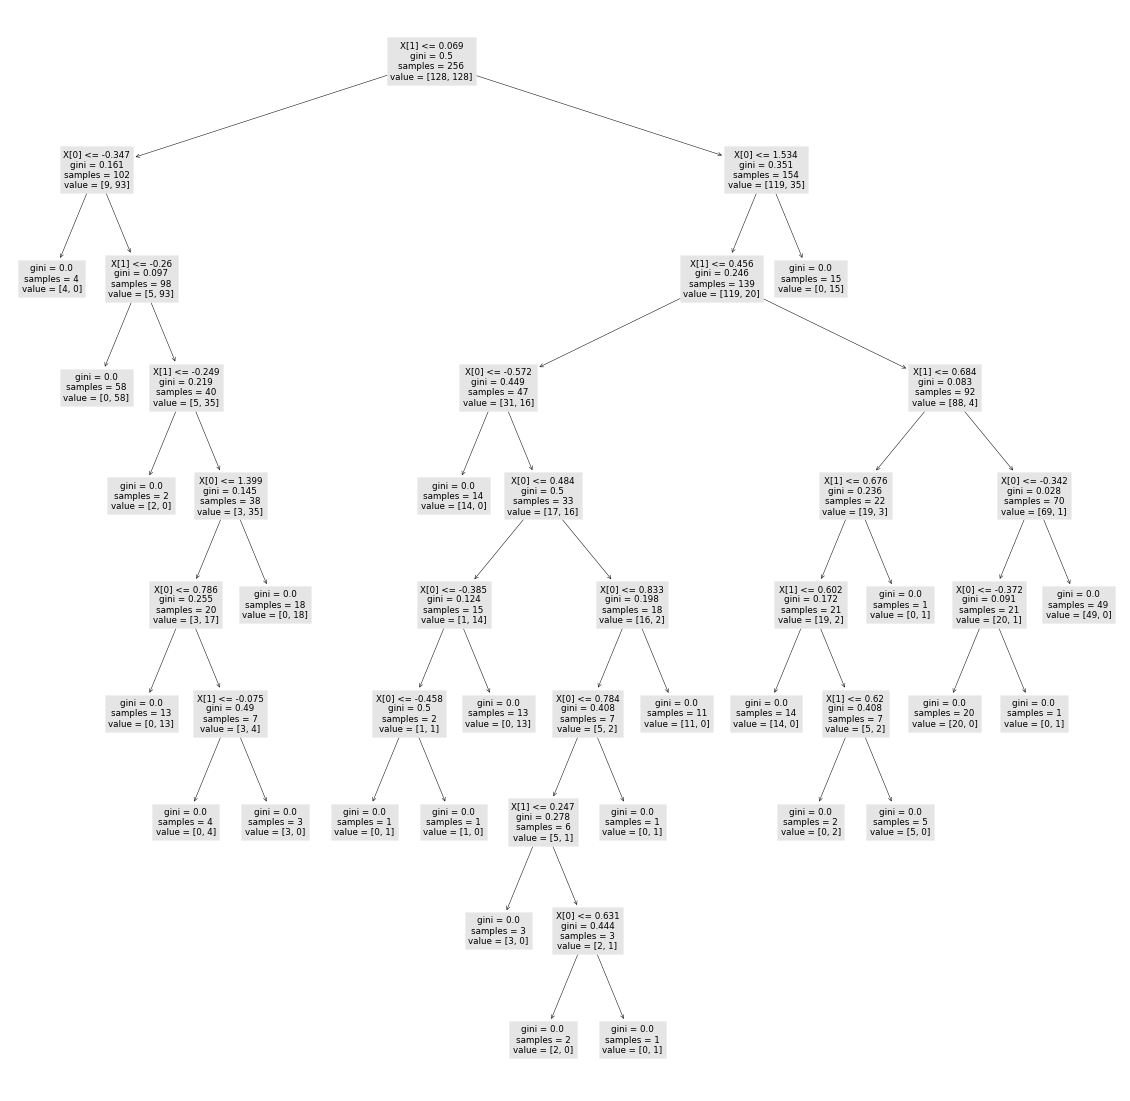

In [67]:
from sklearn.tree import plot_tree


plt.figure(0, (20, 20))
plot_tree(model)
plt.show()

__Критерии информативности:__
* Критерий Джини:
$$
    H(R) = \min_{\sum c_k = 1} \frac{1}{\abs{R}} \sum_{(x_i, y_i) \in R} \sum_{k=1}^K (c_k - [y_i = k])^2 = \sum_{k=1}^K p_k(1-p_k).
$$
* Энтропийный критерий:
$$
    H(R) = \min_{\sum c_k = 1} \left(-\frac{1}{\abs{R}} \sum_{(x_i, y_i) \in R} \sum_{k=1}^K [y_i = k] \log c_k\right) = -\sum_{k=1}^k p_k \log p_k.
$$
* Доля неверно классифицированных объектов:
$$
    H(R) = \min_c \frac{1}{\abs{R}} \sum_{(x_i, y_i) \in R} [y_i \neq c] = \frac{1}{R} \sum_{(x_i, y_i) \in R} [y_i \neq y^*] = 1 - p_{y^*},
$$ где $p_k = \frac{1}{\abs{R}} \sum\limits_{(x_i, y_i)}[y_i = k], \, y^* = \arg\max p_k$.


__Критерии останова:__
* Ограничение максимальной глубины дерева.
* Ограничение максимального количества листьев в дереве.
* Ограничение максимального числа объектов в дереве.
* Ограничение минимального числа объектов в каждом листе.
* Требование, что функионал качества должен увеличиться на некоторое количество процентов.

In [68]:
model = DecisionTreeClassifier(
    criterion='gini', # 'entropy',
    splitter='best',
    max_depth=5,
    max_leaf_nodes=20,
    min_samples_leaf=10,
    min_impurity_decrease=1e-4,
)
model.fit(X, y)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=20,
                       min_impurity_decrease=0.0001, min_samples_leaf=10)

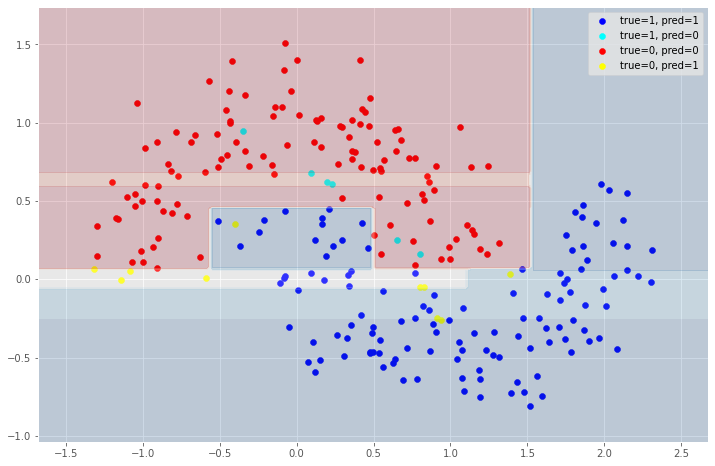

In [69]:
plot_all(X, y, model, proba=True)

In [70]:
out = wg.Output()

def func(criterion, max_depth, min_samples_split, 
         min_samples_leaf, max_leaf_nodes, min_impurity_decrease):
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth if max_depth > 0 else None,
        min_samples_split=max(min_samples_split, 2),
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes if max_leaf_nodes > 1 else None,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42,
    )
    model.fit(X, y)
    with out:
        out.clear_output(wait=True)
        plot_all(X, y, model, proba=True)
        plt.title(model)
        plt.show()
        
wg.interact(func,
    criterion=wg.SelectionSlider(options=['gini', 'entropy']),
    max_depth=wg.IntSlider(min=0, max=20, value=0),
    min_samples_split=wg.IntSlider(min=1, max=128, value=2, step=1),
    min_samples_leaf=wg.IntSlider(min=1, max=128, value=2, step=1),
    max_leaf_nodes=wg.IntSlider(min=0, max=256, value=None, step=1),
    min_impurity_decrease=wg.FloatSlider(min=0.0, value=0.0, max=0.2, step=0.0001),
)
display(out)

interactive(children=(SelectionSlider(description='criterion', options=('gini', 'entropy'), value='gini'), Int…

Output()

## 1.2. Случайный лес

In [71]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(11, criterion='entropy')
model.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=11)

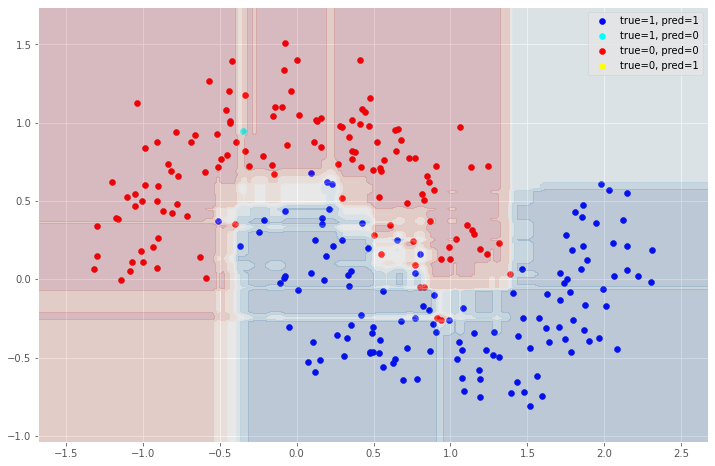

In [72]:
plot_all(X, y, model, proba=True)

In [73]:
# all trees
model.estimators_

[DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=1960801051),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=1304261659),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=938194539),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=801312299),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=1788896595),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=1686028061),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=1646176189),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
                        random_state=168973642),
 DecisionTreeClassifier(criterion='entropy', max_features='auto',
         

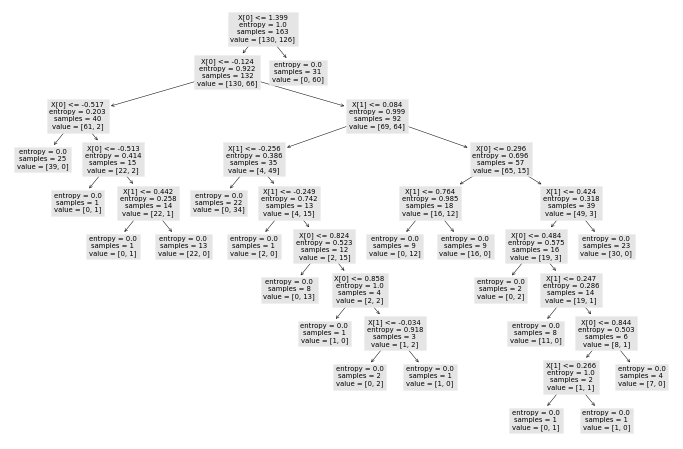

In [74]:
plot_tree(model.estimators_[0]);
plt.show()

In [52]:
out = wg.Output()

def func(n_estimators, criterion, max_depth, min_samples_split, 
         min_samples_leaf, max_leaf_nodes, min_impurity_decrease):
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth if max_depth > 0 else None,
        min_samples_split=max(min_samples_split, 2),
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes if max_leaf_nodes > 1 else None,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42,
    )
    model.fit(X, y)
    with out:
        out.clear_output(wait=True)
        plot_all(X, y, model, proba=True)
        plt.title(model)
        plt.show()
        
wg.interact(func,
    n_estimators=wg.IntSlider(min=9, max=199, step=10),
    criterion=wg.SelectionSlider(options=['gini', 'entropy']),
    max_depth=wg.IntSlider(min=0, max=20, value=0),
    min_samples_split=wg.IntSlider(min=1, max=128, value=2, step=1),
    min_samples_leaf=wg.IntSlider(min=1, max=128, value=2, step=1),
    max_leaf_nodes=wg.IntSlider(min=0, max=256, value=None, step=1),
    min_impurity_decrease=wg.FloatSlider(min=0.0, value=0.0, max=0.2, step=0.0001),
)
display(out)

interactive(children=(IntSlider(value=9, description='n_estimators', max=199, min=9, step=10), SelectionSlider…

Output()

## 1.3. Пример: Титаник

* survived -- спасен или нет;
* pclass -- социально-экономический статус (1 -- upper, 2 -- middle, 3 -- lower);
* sex -- пол;
* age -- возраст;
* sibsp -- число ближайших родственников на борту (муж/жена, брат/сестра);
* parch -- число родителей/детей на борту;
* fare -- плата за проезд;
* embarked -- место посадки.

In [88]:
frame = sns.load_dataset('titanic')
frame = frame[['pclass', 'sex', 'age', 'fare', 'survived']].dropna()
frame['sex'] = (frame.sex == 'female').astype(float)

print('Shape:', frame.shape)
frame.head()

Shape: (714, 5)


,pclass,sex,age,fare,survived
0,3,0.0,22.0,7.2500,0
1,1,1.0,38.0,71.2833,1
2,3,1.0,26.0,7.9250,1
3,1,1.0,35.0,53.1000,1
4,3,0.0,35.0,8.0500,0


In [89]:
X = frame[['pclass', 'sex', 'age', 'fare']].copy()
y = frame['survived'].copy()

In [90]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 571
Test size: 143


In [91]:
from sklearn.model_selection import GridSearchCV


tree = DecisionTreeClassifier(random_state=42)

model = GridSearchCV(tree, dict(
    max_depth=np.arange(1, 10),
    min_samples_leaf=np.arange(1, 7),
#     min_impurity_decrease=np.linspace(0., 1e-2, 10),
), verbose=1, n_jobs=-1)
model.fit(X_fit, y_fit)
model.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


DecisionTreeClassifier(max_depth=5, random_state=42)

In [92]:
classification_metrics(y_test, 
                       model.predict(X_test), 
                       model.predict_proba(X_test),
                       verbose=True);

Accuracy: 0.7202797202797203
Precision: 0.6333333333333333
Recall: 0.6785714285714286
F1-score: 0.6551724137931035
AUC ROC: 0.7128489326765188



In [94]:
from sklearn.model_selection import StratifiedKFold

In [95]:
forest = RandomForestClassifier(random_state=42, n_jobs=1)

model = GridSearchCV(forest, dict(
    n_estimators=(3, 5, 9, 19, 29, 49, 69),
    max_depth=[None] + list(np.arange(1, 10)),
    min_samples_leaf=np.arange(1, 7),
    max_samples=(None, 200, 400)
), verbose=1, n_jobs=-1, cv=StratifiedKFold(random_state=42, shuffle=True))
model.fit(X_fit, y_fit)
model.best_estimator_

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


RandomForestClassifier(max_depth=6, max_samples=400, n_estimators=19, n_jobs=1,
                       random_state=42)

In [96]:
classification_metrics(y_test, 
                       model.predict(X_test), 
                       model.predict_proba(X_test),
                       verbose=True);

Accuracy: 0.7832167832167832
Precision: 0.7450980392156863
Recall: 0.6785714285714286
F1-score: 0.7102803738317757
AUC ROC: 0.7645730706075533



# 2. Регрессия

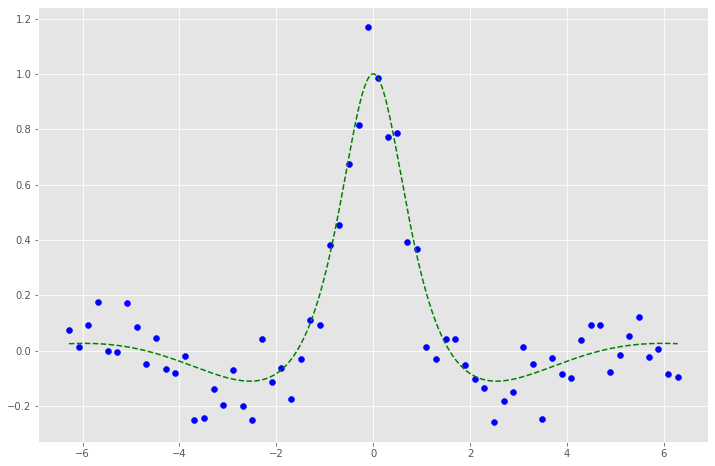

In [103]:
def gt_func(x):
    return np.cos(x) / (np.power(x, 2) + 1)

N = 64
low, high = -2 * np.pi, 2 * np.pi

np.random.seed(42)
X = np.linspace(low, high, N).reshape(-1, 1)
y = gt_func(X[:, 0]) + np.random.normal(scale=0.1, size=N)


x_plt = np.linspace(low, high, 1024)
plt.scatter(X, y, color='blue')
plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
plt.show()

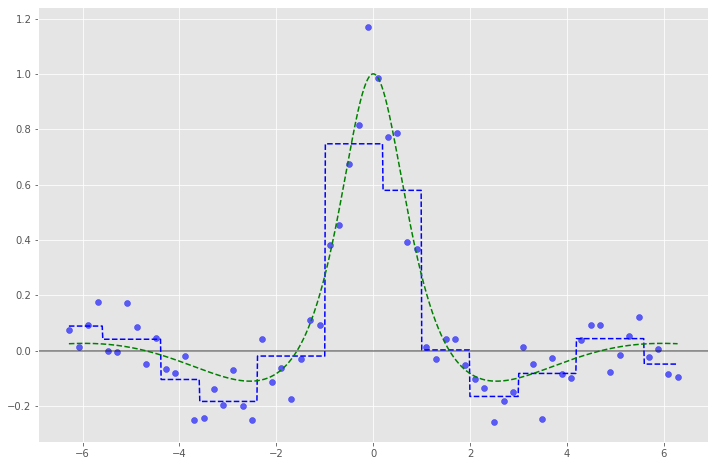

In [108]:
from sklearn.tree import DecisionTreeRegressor


model = DecisionTreeRegressor(max_depth=6, min_samples_leaf=4)
model.fit(X, y)

y_plt = model.predict(x_plt.reshape(-1, 1))

plt.scatter(X, y, color='blue', alpha=0.6)
plt.axhline(0, color='black', alpha=0.5)
plt.plot(x_plt, y_plt, ls='--', color='blue')
plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
plt.show()

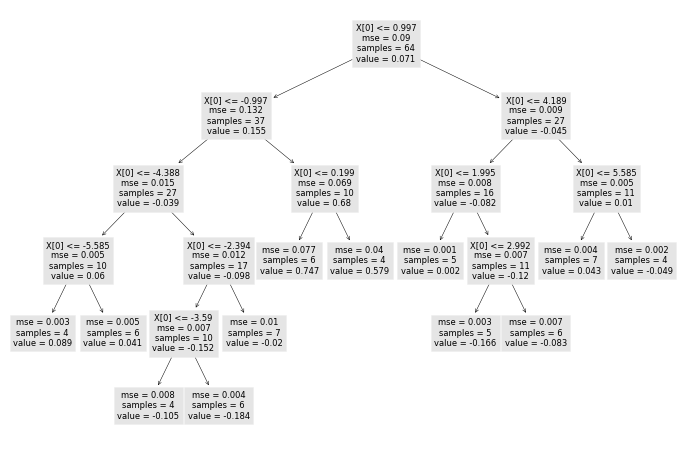

In [109]:
plot_tree(model);
plt.show()

In [105]:
from sklearn.ensemble import RandomForestRegressor


output = wg.Output()

def func(random_forest, criterion, n_estimators, max_depth, min_samples_leaf, min_impurity_decrease):
    if random_forest:
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth if max_depth > 0 else None, 
            min_samples_leaf=min_samples_leaf,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42,
            ccp_alpha=0.0)
    else:
        model = DecisionTreeRegressor(
            criterion=criterion,
            max_depth=max_depth if max_depth > 0 else None, 
            min_samples_leaf=min_samples_leaf,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42,
            ccp_alpha=0.0)
    model.fit(X, y)
    
    with output:
        output.clear_output(wait=True)
        
        y_plt = model.predict(x_plt.reshape(-1, 1))
        plt.scatter(X, y, color='blue', alpha=0.6)
        plt.axhline(0, color='black', alpha=0.5)
        plt.plot(x_plt, y_plt, ls='--', color='blue')
        plt.plot(x_plt, gt_func(x_plt), ls='--', color='green')
        plt.title(model)
        plt.show()
    
wg.interact(func, 
    random_forest=wg.Checkbox(description='Random Forest', value=False),
    n_estimators=wg.IntSlider(min=10, max=300, step=10),
    criterion=wg.SelectionSlider(options=['mse', 'mae']),
    max_depth=wg.IntSlider(min=0, max=20, value=0),
    min_samples_leaf=wg.IntSlider(min=1, max=128, value=1, step=1),
    min_impurity_decrease=wg.FloatLogSlider(min=-7, value=-7, max=-2, step=0.01),)

display(output)

interactive(children=(Checkbox(value=False, description='Random Forest'), SelectionSlider(description='criteri…

Output()